In [ ]:
### Modified version of Hyperparameter-Tuning-CNN-Gamma-Nonlinear-Taiwan.ipynb
### Use three dynamic variables identified to generate best performance in InputVariable-Model-Evaluation-CNNGamma-Taiwan.ipynb
### created by yhw on 1/13/2025

In [1]:
# Import necessary packages
%load_ext autoreload
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
import cmocean

from sklearn.metrics import explained_variance_score, mean_squared_error
import random
import json

# Set working paths
sys.path.append(r'/home/u1281808/High-res-interpretable-dl/src')
os.chdir(r'/home/u1281808/High-res-interpretable-dl')

from models import train_model, complex_conv
from losses import gamma_loss_1d, gamma_mse_metric
from prepare_data_Taiwan import prepare_training_dataset, create_test_train_split

# Set random seeds
tf.random.set_seed(2)
random.seed(2)

2025-01-14 06:31:32.307611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 06:31:32.348489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 06:31:32.349572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 06:31:33.086746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Hyperparameter ranges
layer_neuron_map = {
    3: [16, 32, 64],
    4: [16, 32, 64, 128],
    5: [16, 32, 64, 128, 256]
}
kernel_size_options = [(3, 3), (5, 5), (7, 7)]
learning_rate_options = [1e-5, 1e-4, 1e-3]  # 1e-2 may give too big validation MSE
dropout_options = [0.3, 0.4, 0.5, 0.6, 0.7]
batch_size_options = [16, 32, 64]

# Configuration for data preparation
config = dict(
    y="/home/u1281808/High-res-interpretable-dl/training_data/combined_TReAD_daily_RAINNC_19802021.nc",
    X="/home/u1281808/High-res-interpretable-dl/training_data/combination.nc",
    train_start="1981-01-01",
    train_end="2010-12-31",
    val_start="2011-01-01",
    val_end="2015-12-31",
    test_start="2016-01-01",
    test_end="2021-12-31",
    downscale_variables=['u850', 'v850', 'w850']
)


# Prepare datasets
x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(
    x_train, x_val, x_test, y_train, y_val, y_test
)


x_train_np, x_val_np, x_test_np = x_train.values, x_val.values, x_test.values
y_train_np, y_val_np, y_test_np = y_train['pr'].values, y_val['pr'].values, y_test['pr'].values

input_shape = x_train_np.shape[1:]
output_shape = y_train_np.shape[1]


[########################################] | 100% Completed | 407.41 ms
[########################################] | 100% Completed | 1.13 sms
[########################################] | 100% Completed | 102.44 ms
[########################################] | 100% Completed | 304.47 ms
[########################################] | 100% Completed | 102.47 ms
[########################################] | 100% Completed | 405.95 ms


In [3]:
# Random search for hyperparameter tuning
n_iterations = 10
results = []
best_val_mse = float("inf")
best_config = None
best_model_weights = "best_CNN_Gamma_weights_Taiwan-LearningCurve-10-2.h5"

# Log progress to a file to reduce notebook output
log_file = "hyperparameter_tuning_log.txt"
with open(log_file, "w") as log:
    log.write("Hyperparameter Tuning Log\n")

for i in range(n_iterations):
    # Limit print frequency
    if i % 10 == 0 or i == n_iterations - 1:
        print(f"Iteration {i + 1}/{n_iterations}")

    # Log configuration details to file
    with open(log_file, "a") as log:
        log.write(f"Iteration {i + 1}/{n_iterations}\n")
    
    # Randomly select hyperparameters
    num_layers = random.choice(list(layer_neuron_map.keys()))
    layer_filters = layer_neuron_map[num_layers]
    kernel_size = random.choice(kernel_size_options)
    learning_rate = random.choice(learning_rate_options)
    dropout_rate = random.choice(dropout_options)
    batch_size = random.choice(batch_size_options)

    # Log configuration to file
    with open(log_file, "a") as log:
        log.write(f"Testing configuration: layers={layer_filters}, kernel_size={kernel_size}, "
                  f"learning_rate={learning_rate}, dropout_rate={dropout_rate}, batch_size={batch_size}\n")
    
    # Define model
    cnn_gamma = complex_conv(
        layer_filters=layer_filters,
        bn=True,
        padding='same',
        kernel_size=kernel_size,
        pooling=True,
        dense_layers=[256],
        dense_activation='relu',
        input_shape=input_shape,
        dropout=dropout_rate,
        activation='relu',
        output_shape=output_shape
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model_weights_name = f"CNN_gamma_layers_{len(layer_filters)}_ksize_{kernel_size[0]}x{kernel_size[1]}_" \
                         f"lr_{learning_rate:.0e}_dropout_{dropout_rate}_batch_{batch_size}_Taiwan_LearningCurve.h5"

    # Train the model and track learning curves
    history, trained_model = train_model(
        cnn_gamma,
        [x_train_np, y_train_np],
        x_val=x_val_np,
        y_val=y_val_np,
        loss=gamma_loss_1d,
        epochs=40,
        batch_size=batch_size,
        optimizer=optimizer,
        model_weights_name=model_weights_name,  # Provide a valid path here
        metrics=gamma_mse_metric
    )
    
    train_mse = history.history['gamma_mse_metric']
    val_mse = history.history['val_gamma_mse_metric']

    # Save trial results
    results.append({
        'config': {
            'num_layers': len(layer_filters),
            'kernel_size': kernel_size,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        },
        'train_mse': train_mse,
        'val_mse': val_mse
    })

    final_val_mse = val_mse[-1]
    if final_val_mse < best_val_mse:
        # Log new best model details
        with open(log_file, "a") as log:
            log.write(f"New best model found with val_mse={final_val_mse}\n")
        best_val_mse = final_val_mse
        best_config = {
            'num_layers': len(layer_filters),
            'kernel_size': kernel_size,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        }
        trained_model.save_weights(best_model_weights)

# Evaluate the best model's fit
def evaluate_model_fit(train_mse, val_mse):
    final_train_mse = train_mse[-1]
    final_val_mse = val_mse[-1]

    if abs(final_train_mse - final_val_mse) < 0.01 * final_train_mse:
        return "well-fitting"
    elif final_train_mse > final_val_mse:
        return "underfitting"
    else:
        return "overfitting"

# Log evaluation of the best model
best_result = results[results.index(next(r for r in results if r['config'] == best_config))]
best_fit_status = evaluate_model_fit(best_result['train_mse'], best_result['val_mse'])

with open(log_file, "a") as log:
    log.write(f"The best model is {best_fit_status}.\n")

if best_fit_status == "underfitting":
    with open(log_file, "a") as log:
        log.write("Recommendation: Increase model complexity or train longer.\n")
elif best_fit_status == "overfitting":
    with open(log_file, "a") as log:
        log.write("Recommendation: Add regularization or simplify the model.\n")
else:
    with open(log_file, "a") as log:
        log.write("The model is balanced and generalizes well.\n")

# Plot learning curves for all configurations (after training to avoid intermediate plots)
plt.figure(figsize=(12, 6))
for idx, result in enumerate(results):
    plt.plot(result['train_mse'], label=f"Train Config {idx+1}")
    plt.plot(result['val_mse'], label=f"Val Config {idx+1}")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.05))
plt.title("Learning Curves for Hyperparameter Tuning")
plt.savefig("Learning_Curves_Tuning_Taiwan-10-2.png", dpi=300, bbox_inches='tight')
plt.close()  # Avoid displaying plot in the notebook

# Save results
with open("CNN_gamma_hyperparameter_results_Taiwan-LearningCurve-10-2.json", "w") as f:
    json.dump(results, f)

with open("best_CNN_gamma_hyperparameters_Taiwan-LearningCurve-10-2.json", "w") as f:
    json.dump({'best_config': best_config, 'best_val_mse': best_val_mse, 'fit_status': best_fit_status}, f)

# Log summary to file instead of printing in the notebook
with open(log_file, "a") as log:
    log.write(f"Best hyperparameters saved: {best_config} with validation MSE: {best_val_mse}\n")


Iteration 1/10
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 33, 37, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 33, 37, 16)           448       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 16, 18, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 batch_normalization (Batch  (None, 16, 18, 16)           64        ['average_p

2025-01-14 06:31:47.127246: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-01-14 06:31:47.144357: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Epoch 1/40
684/684 [==============================] - 47s 67ms/step - loss: 0.3479 - gamma_mse_metric: 0.8787 - val_loss: 0.2709 - val_gamma_mse_metric: 0.7217 - lr: 1.0000e-05
Epoch 2/40
684/684 [==============================] - 44s 65ms/step - loss: 0.1727 - gamma_mse_metric: 0.7521 - val_loss: 0.2449 - val_gamma_mse_metric: 0.6399 - lr: 1.0000e-05
Epoch 3/40
684/684 [==============================] - 45s 65ms/step - loss: 0.1331 - gamma_mse_metric: 0.6808 - val_loss: 0.2343 - val_gamma_mse_metric: 0.5508 - lr: 1.0000e-05
Epoch 4/40
684/684 [==============================] - 44s 65ms/step - loss: 0.1163 - gamma_mse_metric: 0.6224 - val_loss: 0.2296 - val_gamma_mse_metric: 0.6309 - lr: 1.0000e-05
Epoch 5/40
684/684 [==============================] - 45s 66ms/step - loss: 0.1063 - gamma_mse_metric: 0.5922 - val_loss: 0.2222 - val_gamma_mse_metric: 1.4238 - lr: 1.0000e-05
Epoch 6/40
684/684 [==============================] - 45s 66ms/step - loss: 0.1043 - gamma_mse_metric: 0.5984 - val

{'config': {'num_layers': 3, 'kernel_size': (7, 7), 'learning_rate': 1e-05, 'dropout_rate': 0.4, 'batch_size': 16}, 'train_mse': [0.8414599299430847, 0.7222318053245544, 0.6603160500526428, 0.6305774450302124, 0.6307864785194397, 0.6392927169799805, 0.6388553977012634, 0.6481098532676697, 0.649199366569519, 0.651633620262146, 0.6665406227111816, 0.6567527055740356, 0.6714462637901306], 'val_mse': [0.6922873854637146, 0.6139836311340332, 0.5349026322364807, 0.662743866443634, 1.0450408458709717, 0.9957059025764465, 1.1225143671035767, 1.3948264122009277, 2.292083501815796, 4.079450607299805, 3.7334251403808594, 3.467978000640869, 2.606809616088867]}


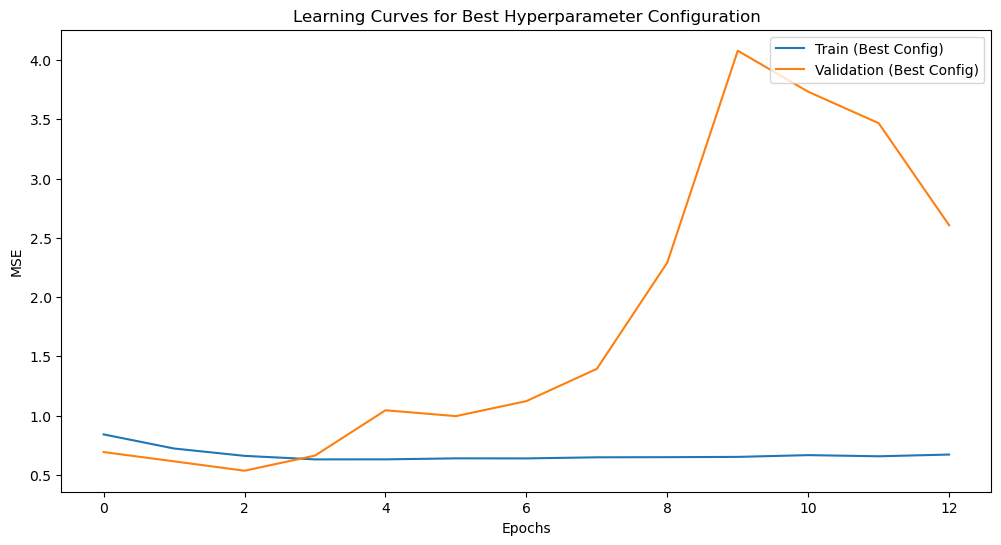

In [5]:


# Plot learning curves for the BEST configuration ONLY 
# to see if the model with the best configuration is overfitting, underfitting, or well-fitting
plt.figure(figsize=(12, 6))

# Get the results for the best configuration
best_result = results[results.index(next(r for r in results if r['config'] == best_config))] 
print(best_result)

# Plot the training and validation MSE for the best configuration
plt.plot(best_result['train_mse'], label=f"Train (Best Config)")  # Updated label
plt.plot(best_result['val_mse'], label=f"Validation (Best Config)")  # Updated label

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(loc='upper right')  # You might adjust the legend location
plt.title("Learning Curves for Best Hyperparameter Configuration")  # Updated title
plt.savefig("Learning_Curves_Best_Config_Taiwan-10-2.png", dpi=300, bbox_inches='tight')  # New filename
#plt.close()


